In [147]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt

filename = 'data2.xlsx'
data = pd.read_excel(filename)
# print data.iloc[0] 
# data.head(10)
data.drop(data.index[:1], inplace=True)

data['PrivateInves'] = data[['Unnamed: 17','Unnamed: 36','Unnamed: 55','Unnamed: 74','Unnamed: 93']].mean(axis=1)
data['ConstrCost'] = data[['Unnamed: 22','Unnamed: 41','Unnamed: 60','Unnamed: 79','Unnamed: 98']].mean(axis=1)
data['CPI'] = data[['Unnamed: 26','Unnamed: 45','Unnamed: 64','Unnamed: 83','Unnamed: 102']].mean(axis=1)
data['Population'] = data[['Unnamed: 29','Unnamed: 48','Unnamed: 67','Unnamed: 86','Unnamed: 105']].mean(axis=1)

data.rename(columns={'Unnamed: 5' : 'Area', 'Unnamed: 6':'Lot' ,'Unnamed: 10':'Duration' ,'Unnamed: 11' : 'UnitPrice','OUTPUTS':'SalePrice'}, inplace=True)
data = data[['SalePrice','Area','Lot','Duration','PrivateInves','UnitPrice','ConstrCost','CPI','Population']]

# missing value (N/A)
# data = data.fillna(data.mean())

#standardize all columns
data = data.apply(zscore) 

# split data into train 0.8 / test 0.2
X_train, X_test, y_train, y_test = train_test_split(data.values[:,1:], data.values[:,0], test_size=0.2, random_state=1)

data.head(3)

,SalePrice,Area,Lot,Duration,PrivateInves,UnitPrice,ConstrCost,CPI,Population
1,0.674631,0.789443,1.00913,4.64918,-0.294867,0.112502,-0.562734,-0.426194,0.579670
2,2.99932,3.26174,1.45864,7.99258,-0.170040,1.82193,0.151800,0.381979,1.156695
3,-0.155616,1.70614,0.84567,4.17155,-0.914354,-0.460658,-0.804024,-0.942484,-0.016839


In [148]:
def avg(L=[]):
    return reduce(lambda x,y:x+y,L)*1.0/len(L)

In [149]:
# lasso regression

alpha_list = []
for i in range(10):
    alpha_list.append(2.0/(2**(i+1)))
                                            
val_mse_dic = {}
val_mse_list = []
train_mse_list = []
model_dic = {}

for alpha in alpha_list:
    
    model = Lasso(alpha=alpha, max_iter=1000)
    for i in range(10):
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        model.fit(X_train_tmp, y_train_tmp)
        
        # training results
        y_train_pred = model.predict(X_train_tmp)
        train_mse = mean_squared_error(y_train_tmp, y_train_pred)
        train_mse_list.append(train_mse)
        
        # test model in validation set
        y_val_pred = model.predict(X_val_tmp)
        val_mse = mean_squared_error(y_val_tmp, y_val_pred)
        val_mse_list.append(val_mse)
        
    val_mse_dic[alpha]=avg(val_mse_list)
    model_dic[alpha]=model
    print 'alpha =', alpha, '\t avg val MSE =', avg(val_mse_list),'\t avg training MSE =', avg(train_mse_list)

alpha = 1.0 	 avg val MSE = 0.46437109215405015 	 avg training MSE = 1.05721080736995
alpha = 0.5 	 avg val MSE = 0.2993034183009032 	 avg training MSE = 0.6791396814866335
alpha = 0.25 	 avg val MSE = 0.215859651724209 	 avg training MSE = 0.49010411854497465
alpha = 0.125 	 avg val MSE = 0.1684675681997582 	 avg training MSE = 0.38377161439029184
alpha = 0.0625 	 avg val MSE = 0.1379123787755293 	 avg training MSE = 0.31643393296976435
alpha = 0.03125 	 avg val MSE = 0.11686896642680197 	 avg training MSE = 0.2703378070704489
alpha = 0.015625 	 avg val MSE = 0.10168995578624347 	 avg training MSE = 0.23657438044969556
alpha = 0.0078125 	 avg val MSE = 0.09020776811877836 	 avg training MSE = 0.2105535375789922
alpha = 0.00390625 	 avg val MSE = 0.0812947704055897 	 avg training MSE = 0.19008616349066168
alpha = 0.001953125 	 avg val MSE = 0.07423224292010394 	 avg training MSE = 0.17363005653277508


In [150]:
# select model
alpha = min(val_mse_dic)
model = model_dic[alpha]

# test model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print '(mean, std) of training error is',(avg(train_mse_list),np.std(train_mse_list))
print 'testing error is ', test_mse
print 'model score is ',model.score(X_test,y_test)

pd.DataFrame({'y_test_true': y_test, 'y_test_pred': y_test_pred, 'difference': y_test-y_test_pred}).head(10)

(mean, std) of training error is (0.17363005653277508, 0.30507765853259666)
testing error is  0.05875262808846285
model score is  0.950726343418042


,difference,y_test_pred,y_test_true
0,-0.229526,1.900454,1.67093
1,0.0663869,-0.985830,-0.919443
2,-0.165585,-0.737253,-0.902838
3,0.013457,-0.426449,-0.412992
4,0.294624,1.293279,1.5879
5,-0.162734,-0.258561,-0.421295
6,-0.179365,0.272824,0.0934586
7,0.0183835,-1.037456,-1.01907
8,-0.189242,0.863873,0.674631
9,-0.200297,1.040978,0.840681


Text(0,0.5,'sale price')

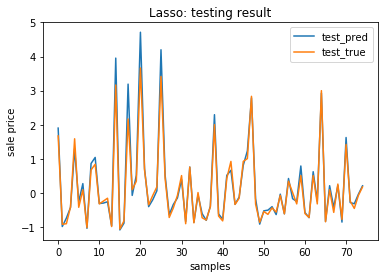

In [151]:
%matplotlib inline
plt.plot(list(range(len(y_test_pred))),y_test_pred, label='test_pred')
plt.plot(list(range(len(y_test))),y_test, label='test_true')
plt.title('Lasso: testing result')
plt.legend()
plt.xlabel('samples')
plt.ylabel('sale price')

In [152]:
# Ridge regression

alpha_list = []
for i in range(10):
    alpha_list.append(2.0/(2**(i+1)))

val_mse_dic = {}
val_mse_list = []
train_mse_list = []
model_dic = {}

for alpha in alpha_list:
    
    model = Ridge(alpha=alpha, max_iter=1000)
    for i in range(10):
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        model.fit(X_train_tmp, y_train_tmp)
        
        # training results
        y_train_pred = model.predict(X_train_tmp)
        train_mse = mean_squared_error(y_train_tmp, y_train_pred)
        train_mse_list.append(train_mse)
        
        # test model in validation set
        y_val_pred = model.predict(X_val_tmp)
        val_mse = mean_squared_error(y_val_tmp, y_val_pred)
        val_mse_list.append(val_mse)
        
    val_mse_dic[alpha]=avg(val_mse_list)
    model_dic[alpha]=model
    print 'alpha =', alpha, '\t avg val MSE =', avg(val_mse_list),'\t avg training MSE =', avg(train_mse_list)

alpha = 1.0 	 avg val MSE = 0.011018703368946397 	 avg training MSE = 0.025290773222336034
alpha = 0.5 	 avg val MSE = 0.011062897172147469 	 avg training MSE = 0.02526085215529611
alpha = 0.25 	 avg val MSE = 0.011097612107197634 	 avg training MSE = 0.025245242276240736
alpha = 0.125 	 avg val MSE = 0.01112368746354819 	 avg training MSE = 0.025236298972021898
alpha = 0.0625 	 avg val MSE = 0.011143097600426597 	 avg training MSE = 0.025230695706168715
alpha = 0.03125 	 avg val MSE = 0.011157668374631537 	 avg training MSE = 0.025226909669504805
alpha = 0.015625 	 avg val MSE = 0.01116878869450745 	 avg training MSE = 0.02522419440820472
alpha = 0.0078125 	 avg val MSE = 0.011177443772655558 	 avg training MSE = 0.02522215555335544
alpha = 0.00390625 	 avg val MSE = 0.011184316115664554 	 avg training MSE = 0.025220569240517115
alpha = 0.001953125 	 avg val MSE = 0.011189877422467253 	 avg training MSE = 0.02521930006928228


In [153]:
# select model
alpha = min(val_mse_dic)
model = model_dic[alpha]

# test model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print '(mean, std) of training error is',(avg(train_mse_list),np.std(train_mse_list))
print 'testing error is ', test_mse
print 'model score is ',model.score(X_test,y_test)

pd.DataFrame({'y_test_true': y_test, 'y_test_pred': y_test_pred, 'difference': y_test-y_test_pred}).head(10)

(mean, std) of training error is (0.02521930006928228, 2.4776778148862255e-05)
testing error is  0.058612947733198556
model score is  0.9508434881668042


,difference,y_test_pred,y_test_true
0,-0.256089,1.927017,1.67093
1,0.0675262,-0.986969,-0.919443
2,-0.0758471,-0.826991,-0.902838
3,-0.0105535,-0.402439,-0.412992
4,0.295365,1.292538,1.5879
5,-0.153686,-0.267609,-0.421295
6,-0.217673,0.311132,0.0934586
7,0.0248828,-1.043955,-1.01907
8,-0.196497,0.871128,0.674631
9,-0.205904,1.046585,0.840681


Text(0,0.5,'sale price')

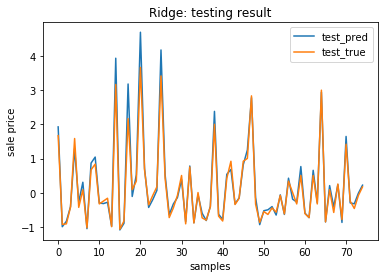

In [138]:
%matplotlib inline
plt.plot(list(range(len(y_test_pred))),y_test_pred, label='test_pred')
plt.plot(list(range(len(y_test))),y_test, label='test_true')
plt.title('Ridge: testing result')
plt.legend()
plt.xlabel('samples')
plt.ylabel('sale price')